In [22]:
import numpy as np
import rasterio
from rasterio.features import rasterize
import geopandas as gpd

In [23]:
import os
os.getcwd()
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code_mgwr")

In [24]:
grid_with_wards= gpd.read_file('data/cleaned/grid_pop_mgwr04.geojson')

In [25]:
grid_with_wards.columns

Index(['grid_id', 'row', 'col', 'illum_vol_density', 'light_intensity',
       'poi_kde', 'Id', 'Ward_No', 'POP', 'beta_intercept', 'beta_illum_vol',
       'beta_light_intensity', 'beta_poi_kde', 'poi_kde_scaled',
       'illum_vol_density_std', 'light_intensity_std', 'poi_kde_scaled_std',
       'Predicted_Z_Y', 'Predicted_log_Y', 'w_raw', 'w_pt', 'w_initial',
       'w_trim', 'w_final_trim', 'population_final_trim', 'pop_floor',
       'remainder', 'pop_int', 'geometry'],
      dtype='object')

In [26]:
total_pop_vector = grid_with_wards['pop_int'].sum()
print(f"Vector format total population: {total_pop_vector:,}")

Vector format total population: 3,053,908


In [27]:
print(f"Total grids in GDF: {len(grid_with_wards)}")
print(f"Grids with valid geometry: {grid_with_wards.geometry.is_valid.sum()}")
print(f"Grids with population > 0: {(grid_with_wards['pop_int'] > 0).sum()}")
print(f"Any negative population: {(grid_with_wards['pop_int'] < 0).sum()}")
print(f"Any NaN values: {grid_with_wards['pop_int'].isna().sum()}")

Total grids in GDF: 38906
Grids with valid geometry: 38906
Grids with population > 0: 14008
Any negative population: 0
Any NaN values: 0


In [28]:
template_path = 'data/cleaned/illum_vol_cropped.tif'
with rasterio.open(template_path) as src:
    meta = src.meta.copy()

# set two arrays for bands
nodata = meta.get('nodata', None)
dtype = 'float32'
pop_arr = np.full((meta['height'], meta['width']), nodata, dtype=dtype)
id_arr  = np.full((meta['height'], meta['width']), nodata, dtype=dtype)

In [29]:
# 3. Prepare empty arrays: population and Id
for _, row in grid_with_wards.iterrows():
    r, c = int(row['row']), int(row['col'])
    pop_arr[r, c] = row['pop_int']
    id_arr[r, c]  = row['Id']

# 4. Update meta: output two bands, set dtype and nodata
meta.update({
    'count': 2,
    'dtype': dtype,
    'nodata': nodata
})

In [30]:
out_path = 'population_and_id_100m_mgwr04.tif'
with rasterio.open(out_path, 'w', **meta) as dst:
    dst.write(pop_arr, 1)  # Band 1: population_final_trim
    dst.write(id_arr, 2)  # Band 2: Id

print(f"Written 100 m raster with population and Id to: {out_path}")


Written 100 m raster with population and Id to: population_and_id_100m_mgwr04.tif


In [31]:
from rasterio.features import rasterize


# 1 GEEMAP

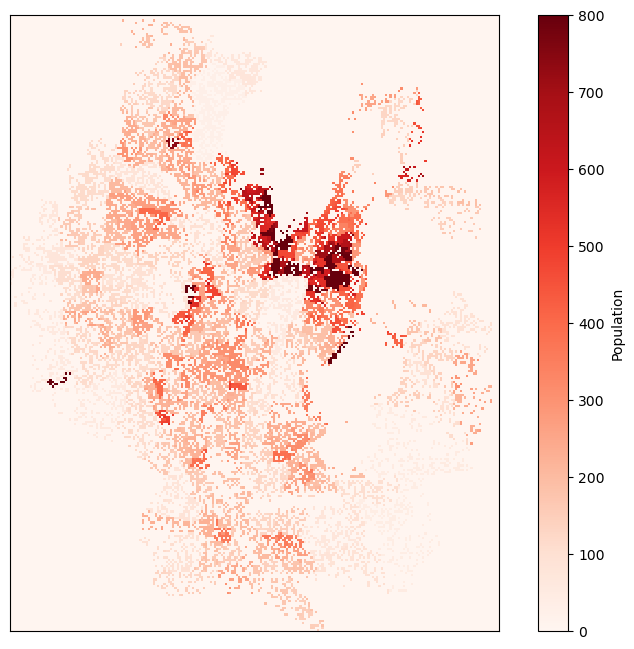

In [32]:
import rasterio
import matplotlib.pyplot as plt

# Path to the raster file
path = 'population_and_id_100m_mgwr04.tif'

# Open the raster file
with rasterio.open(path) as src:
    # Read the first band (population data)
    band1 = src.read(1)

    # Plot the raster
    plt.figure(figsize=(10, 8))
    plt.imshow(band1, cmap='Reds', interpolation='none',vmin=0,vmax=800)
    plt.colorbar(label='Population')
    # plt.xlabel('Pixel X')
    # plt.ylabel('Pixel Y')
    plt.grid(False)

        # Remove axis numbers/ticks
    plt.xticks([])
    plt.yticks([])
    plt.savefig('image/analysis/population_raster_100m_mgwr04.png', dpi=300, bbox_inches='tight')
    plt.show()


In [33]:
# try:
#     with rasterio.open('population_and_id_100m_mgwr04.tif') as src:
#         raster_data = src.read(1)
#
#         raster_data = np.where(raster_data == src.nodata, 0, raster_data)
#         total_pop_raster = np.sum(raster_data)
#         print(f"Raster format total population: {total_pop_raster:,}")
#         print(f"Difference: {total_pop_raster - total_pop_vector:,}")
#
#         if total_pop_raster == total_pop_vector:
#             print("✅ Population perfectly conserved!")
#         else:
#             print("❌ Population conservation error detected!")
#
# except FileNotFoundError:
#     print("Raster file not found - run rasterization first")

In [34]:
# import geopandas as gpd
#
# # 1. Select only the fields you need
# points_gdf = grid_with_wards[['Id', 'pop_int', 'geometry']].copy()
#
# # 2. Write to GeoJSON
# points_gdf.to_file('grid_points_population.geojson', driver='GeoJSON')
#
# # 3. (Optional) Preview a few entries
# points_gdf.head()